#### This notebook will apply dimensionality reduction to the distance matrices generated from combine_all.ipynb or data_analysis.ipynb


In [47]:
from sklearn.manifold import MDS
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import re

MODELS = ["1M", "3M", "8M", "21M", "33M"]
PROMPTS = ["A", "B"]
NUM_TEMPS = 9
NUM_SEEDS = 3
NUM_EXPERIMENTS = 800
NUM_TOKENS = 23 # (num_tokens_to_generate + prompt_length - 1)
N_COMPONENTS = 10

path = "data/distance_matrices/linear_distance_matrix_alpha_1.npy"
distance_matrix = np.load(path)
data_name = path.split("/")[-1].split(".")[0]

print(distance_matrix.shape)
print(data_name)

(270, 270)
linear_distance_matrix_alpha_1


In [35]:
### set up the labeling. 
graph_labels = []
for model in MODELS:
    for prompt in PROMPTS:
        for T in range(NUM_TEMPS):
            for S in range(NUM_SEEDS):
                graph_labels.append((model, prompt, f"T_{T}", f"S_{S}"))

df = pd.DataFrame(graph_labels, columns=["model", "prompt", "temperature", "seed"])
df.head()

,model,prompt,temperature,seed
0,1M,A,T_0,S_0
1,1M,A,T_0,S_1
2,1M,A,T_0,S_2
3,1M,A,T_1,S_0
4,1M,A,T_1,S_1


/opt/anaconda3/envs/lipshutz/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


mds_linear_distance_matrix_alpha_2.png


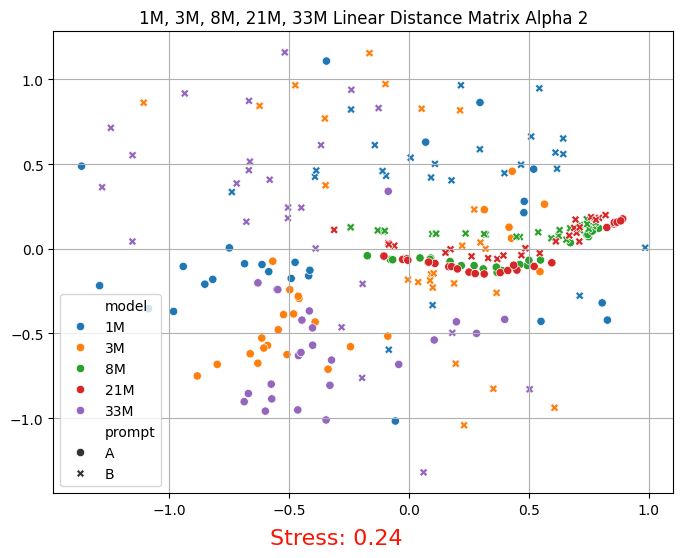

In [36]:
# Graph it in 2D.   
mds = MDS(n_components=2, metric=False, dissimilarity='precomputed', normalized_stress=True)
embedded_data = mds.fit_transform(distance_matrix)

stress = mds.stress_
stress = 0.0 if stress <= 0 else round(stress, 2 - int(math.floor(math.log10(stress))) - 1) # Round function. 
stress_color = "black"
if stress >= 0.2:
    stress_color = "#fc1403"
elif stress < 0.05:
    stress_color = "#7ffc03"

# Get dataframe set up with the embedding values. 
df["x"] = embedded_data[:, 0]
df["y"] = embedded_data[:, 1]


plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.scatterplot(data=df, x='x', y='y', hue='model', style="prompt", palette='tab10')
plt.grid(True)
plt.xlabel("")
plt.ylabel("")
plt.text(
    0.35, -.075,
    f"Stress: {stress}",
    color=stress_color,

    fontsize=16,
    transform=plt.gca().transAxes,
    verticalalignment="top"
)

title = ", ".join(MODELS[:-1]) + ", " + MODELS[-1] + " " + data_name.replace("_", " ")
title = re.sub(r'(?<=\s)([a-z])', lambda m: m.group(1).upper(), title)
plt.title(title)

save_path = "./results/mds_clusters/"
save_name = "mds_"+data_name +".png"
plt.savefig(save_name)
print(save_name)


#### I can also graph it in 3D!

/opt/anaconda3/envs/lipshutz/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


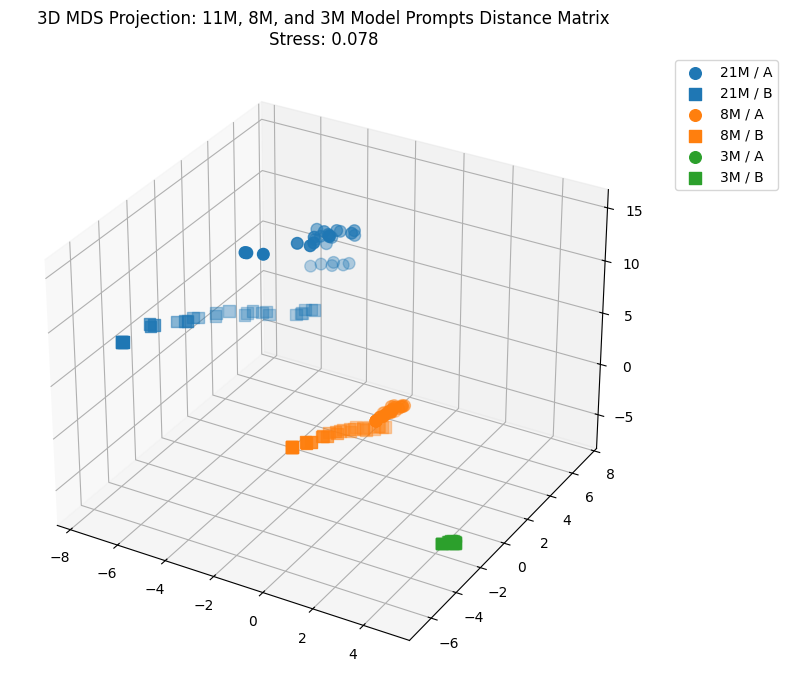

Stress: 0.078


In [77]:
### Graph it in 3D
mds_3d = MDS(n_components=3, metric=True, dissimilarity='precomputed', normalized_stress=True)
embedded_data_3d = mds_3d.fit_transform(distance_matrix)

df_3d = None
df_3d = pd.DataFrame(graph_labels, columns=["model", "prompt", "temperature", "seed"])
df_3d["x"] = embedded_data_3d[:, 0]
df_3d["y"] = embedded_data_3d[:, 1]
df_3d["z"] = embedded_data_3d[:, 2]

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
# Get color palette from Seaborn
palette = sns.color_palette("tab10", n_colors=df["model"].nunique())
model_to_color = dict(zip(df["model"].unique(), palette))

# Assign marker shapes for different prompts
markers = ['o', 's', '^', 'D', 'P', 'X']  # expand if needed
prompt_to_marker = {p: markers[i % len(markers)] for i, p in enumerate(df["prompt"].unique())}

# Plot points by model and prompt
for model in df_3d["model"].unique():
    for prompt in df_3d["prompt"].unique():
        subset = df_3d[(df_3d["model"] == model) & (df_3d["prompt"] == prompt)]
        ax.scatter(
            subset["x"], subset["y"], subset["z"],
            color=model_to_color[model],
            marker=prompt_to_marker[prompt],
            s=70,
            label=f"{model} / {prompt}"
        )

# Add titles and labels
stress = round(stress, 2 - int(math.floor(math.log10(mds_3d.stress_))) - 1)
ax.set_title(f"3D MDS Projection: 11M, 8M, and 3M Model Prompts Distance Matrix\nStress: {stress}")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")

# Optional: remove axes gridlines for a cleaner look
ax.grid(True)

# Create unique legend entries
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
print("Stress:", stress)


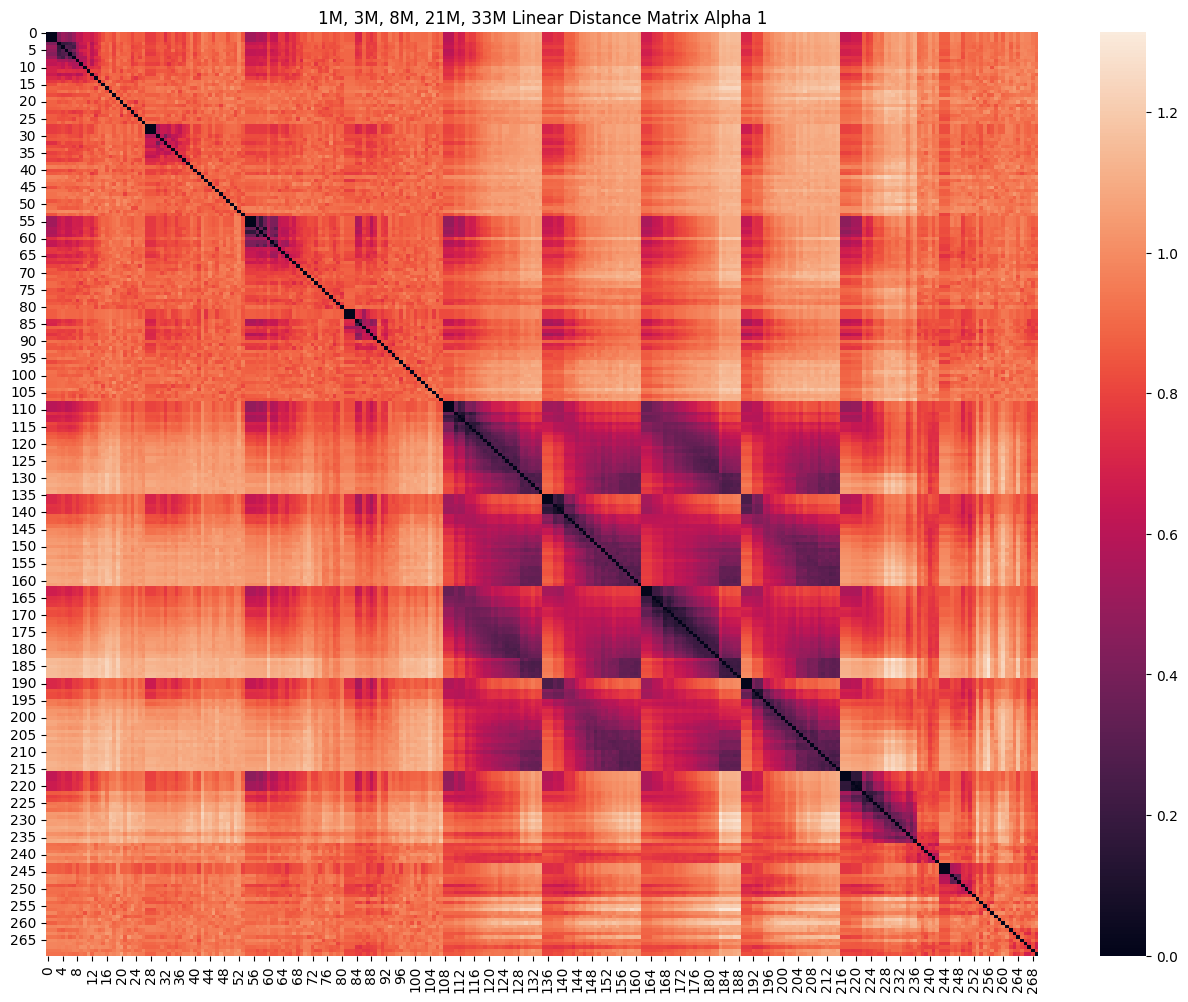

In [48]:
plt.figure(figsize=(16, 12)) # Adjust figure size as needed
sns.heatmap(distance_matrix)
title = ", ".join(MODELS[:-1]) + ", " + MODELS[-1] + " " + data_name.replace("_", " ")
title = re.sub(r'(?<=\s)([a-z])', lambda m: m.group(1).upper(), title)
plt.title(title)
save_path = "./results/mds_clusters/"
save_name = "distance_matrix_"+data_name +".png"
plt.savefig(save_name)